# \[set-up\], imports
See README for more details about installing necessary packages and setting up your environment.

In [28]:
import numpy as np
import matplotlib as mpl
import astropy
from astropy import log
from astropy.visualization import quantity_support
quantity_support()

import pint
import pint.fitter
from pint.fitter import ConvergenceFailure

import pint_pal as pp
import pint_pal.report
import pint_pal.lite_utils as lu
import pint_pal.plot_utils as pu
from pint_pal.timingconfiguration import TimingConfiguration

import os
import sys
import git
import platform
import copy

# notebook gives interactive plots but not until the kernel is done
#%matplotlib notebook
# inline gives non-interactive plots right away
%matplotlib inline

# Set logging level (PINT uses loguru)
log.setLevel("INFO") # Set desired verbosity of log statements (DEBUG/INFO/WARNING/ERROR)
pint.logging.setup(level="WARNING", usecolors=True)

2

# develop/update \[prenoise\] timing solution

Load configuration (`.yaml`) file, get TOAs and timing model; if you're running from the root of the git distribution, simply edit the `.yaml` file name, otherwise include relevant paths to the `.yaml` file, and `.par`/`.tim` directories as kwargs (see commented example).

In [19]:
config = "configs/path-to-your-config.yaml"  # fill in actual path
par_directory = None   # default location
tim_directory = None   # default location
tc = TimingConfiguration(config, par_directory=par_directory, tim_directory=tim_directory)

In [20]:
# Summary report will be added to throughout the notebook & rendered at the end
report = pint_pal.report.Report(title=f"{tc.get_source()} PINT combination summary")
report.add_markdown("Software", f"OS: {platform.platform()}")
report.add_markdown("Software", f"Python version: {sys.version}")
report.add_markdown("Software", f"Numpy version: {np.__version__}")
report.add_markdown("Software", f"Matplotlib version: {mpl.__version__}")
report.add_markdown("Software", f"Astropy version: {astropy.__version__}")
report.add_markdown("Software", f"PINT version: {pint.__version__}")
report.add_markdown("Software", f"PINT Pal version: {pp.__version__}")

#repo = git.Repo(config, search_parent_directories=True)
#git_hash = repo.git.rev_parse(repo.head, short=True) + (" (dirty)" if repo.is_dirty() else "")
#pint_pipeline_dir = os.path.join(repo.working_dir, 'pipelines', 'pint')
parfile_path = os.path.join(tc.config['par-directory'], tc.config['timing-model'])
#parfile_path = os.path.normpath(os.path.join(pint_pipeline_dir, parfile_path))
timfile_paths = [os.path.join(tc.config['tim-directory'], timfile) for timfile in tc.config['toas']]
#timfile_paths = [os.path.normpath(os.path.join(pint_pipeline_dir, timfile_path)) for timfile_path in timfile_paths]
timfile_paths = '\n'.join(timfile_paths)

#report.add_markdown("Software", f"DR3 git hash: {git_hash}")
report.add_markdown("Software", f"Par file:")
report.add_verbatim("Software", parfile_path)
report.add_markdown("Software", f"Tim files:")
report.add_verbatim("Software", timfile_paths)

OS: Linux-4.18.0-513.24.1.el8_9.x86_64-x86_64-with-glibc2.28

Python version: 3.12.9 | packaged by conda-forge | (main, Feb 14 2025, 08:00:06) [GCC 13.3.0]

Numpy version: 1.26.4

Matplotlib version: 3.10.0

Astropy version: 6.1.6

PINT version: 1.1.1

PINT Pal version: 0.4.1

Par file:

```
par/J0030+0451_PINT_20240705_prenoise.nb.par
```


Tim files:

```
tim/J0030+0451_PINT_20220302.nb.tim
tim/J0030+0451.tim
```


In [24]:
# To combine TOAs, assumption is that cuts have already been applied properly
mo,to = tc.get_model_and_toas(apply_initial_cuts=False,usepickle=False)

# Apply manual cuts
tc.manual_cuts(to)

# Computing pulse numbers ensures param changes in the model will not break phase connection
to.compute_pulse_numbers(mo)

# Set non-binary epochs to the center of the data span
lu.center_epochs(mo,to)

# Summarize TOAs present
summary = to.get_summary()
report.add_markdown("Summary of TOAs", f"```\n{summary}```")

INFO: Par file created: 2024-07-05T11:36:11.143036 [pint_pal.timingconfiguration]
INFO: Specified TOA excision keys: set() [pint_pal.timingconfiguration]
INFO: Selecting 22451 TOAs out of 22451 (0 removed based on manual cuts, specified keys). [pint_pal.utils]
INFO: Specified TOA excision keys: set() [pint_pal.timingconfiguration]
INFO: Selecting 22451 TOAs out of 22451 (0 removed based on manual cuts, specified keys). [pint_pal.utils]
INFO: Specified TOA excision keys: {'bad-file'} [pint_pal.timingconfiguration]


INFO: Selecting 22338 TOAs out of 22451 (113 removed based on manual cuts, specified keys). [pint_pal.utils]


```
Number of TOAs:  22338
Number of commands:  [1, 2]
Number of observatories: 2 ['arecibo', 'meerkat']
MJD span:  53394.855 to 60149.193
Date span: 2005-01-24 20:31:47.499402113 to 2023-07-24 04:37:43.011109372
arecibo TOAs (19458):
  Min freq:      422.186 MHz
  Max freq:      2397.713 MHz
  Min error:     0.089 us
  Max error:     140 us
  Median error:  2.17 us
meerkat TOAs (2880):
  Min freq:      907.738 MHz
  Max freq:      1659.753 MHz
  Min error:     0.403 us
  Max error:     44.8 us
  Median error:  4.31 us
```

In [25]:
# Define the fitter object and plot pre-fit residuals
fo = tc.construct_fitter(to,mo)
pu.plot_residuals_time(fo, restype='prefit')
report.add_plot("Prefit residuals")
if mo.is_binary:
    pu.plot_residuals_orb(fo, restype='prefit')
    report.add_plot("Prefit residuals")
pu.plot_residuals_freq(fo, restype='prefit')
report.add_plot("Prefit residuals")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
# Set free params based on list in the config file (want to update JUMP handling differently soon)
fo.model.free_params = tc.get_free_params(fo)

# Do the fit
try:
    fo.fit_toas(maxiter=tc.get_niter())
    fo.model.CHI2.value = fo.resids.chi2
except ConvergenceFailure:
    run_Ftest = False
    log.warning('Failed to converge; moving on with best result, but should address before final version.')

```
Fitted model using downhill_gls method with 20 free parameters to 22338 TOAs
Prefit residuals Wrms = 205.5089364273351 us, Postfit residuals Wrms = 2.2192591889523823 us
Chisq = 90862.006 for 22317 d.o.f. for reduced Chisq of 4.071

PAR                        Prefit                  Postfit            Units
=================== ==================== ============================ =====
PSR                           J0030+0451 J0030+0451                   None
EPHEM                              DE440 DE440                        None
CLOCK                       TT(BIPM2021) TT(BIPM2021)                 None
UNITS                                TDB TDB                          None
START                            51275.5                      53394.9 d 
FINISH                           59645.2                      60149.2 d 
INFO                                  -f -f                           None
TIMEEPH                             FB90 FB90                         None
T2CMETHOD                       IAU2000B IAU2000B                     None
DILATEFREQ                             N                              None
DMDATA                                 N                              None
NTOA                               24863                              None 
CHI2                             92635.7                        90862  
CHI2R                            3.73336                      4.07143  
TRES                             2.20898                      2.21926 us 
POSEPOCH                           56772                              d 
PX                               2.96159                    2.956(20) mas 
ELONG                  8d54m37.25591628s  8d54m37.25591222s +/- 5.8e-06 arcsec 
ELAT                   1d26m44.51734954s  1d26m44.51717582s +/- 0.00024 arcsec 
PMELONG                          -5.5116                  -5.5112(13) mas / yr 
PMELAT                           3.17071                      3.25(6) mas / yr 
ECL                             IERS2010 IERS2010                     None
F0                               205.531      205.530699059451024(34) Hz 
PEPOCH                             56772                              d 
F1                          -4.29797e-16           -4.297954(4)×10⁻¹⁶ Hz / s 
CORRECT_TROPOSPHERE                    Y                              None
PLANET_SHAPIRO                         Y                              None
NE_SW                                7.9                              1 / cm3 
NE_SW1                                 0                              1 / (yr cm3) 
SWP                                    2                               
SWM                                    0                              None 
DM                               4.33448                     4.356(6) pc / cm3 
DM1                           2.6109e-05               2.613(26)×10⁻⁵ pc / (yr cm3) 
DMEPOCH                            56772                              d 
DM2                          7.70111e-06                8.12(11)×10⁻⁶ pc / (yr2 cm3) 
FDJUMPDM1                     0.00289084                     0.024(6) pc / cm3 
FDJUMPLOG                              Y                              None
FD1JUMP1                    -9.80457e-06               -5.6(2.0)×10⁻⁶ s 
FD2JUMP1                     -0.00022196                  -0.00022(6) s 
FD3JUMP1                     0.000157748                   0.00016(4) s 
FD4JUMP1                    -5.45722e-05               -5.3(1.5)×10⁻⁵ s 
FD1JUMP2                     0.000202527                   0.00020(5) s 
TZRMJD                           55673.6                              d 
TZRSITE                               AO AO                           None
TZRFRQ                               424                              MHz 
JUMP1                        0.000319899                       0.0(5) s 
JUMP2                        0.000313021                       0.0(5) s 
JUMP3                        0.000323532                       0.0(5) s 
JUMP4                         0.00612731                       0.0(5) s 

Derived Parameters:
Period = 0.0048654532124699475±0.0000000000000000008 s
Pdot = (1.0174388±0.0000010)×10⁻²⁰
Characteristic age = 7.577e+09 yr (braking index = 3)
Surface magnetic field = 2.25e+08 G
Magnetic field at light cylinder = 1.799e+04 G
Spindown Edot = 3.487e+33 erg / s (I=1e+45 cm2 g)

Parallax distance = 338.30±2.27 pc

```

chi-squared decreased during fit by 779071002.4893082
Fitter has converged


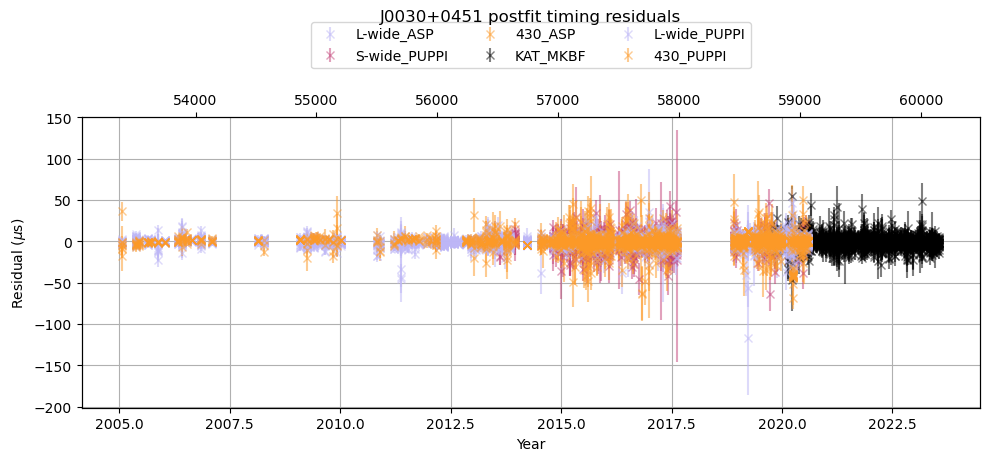

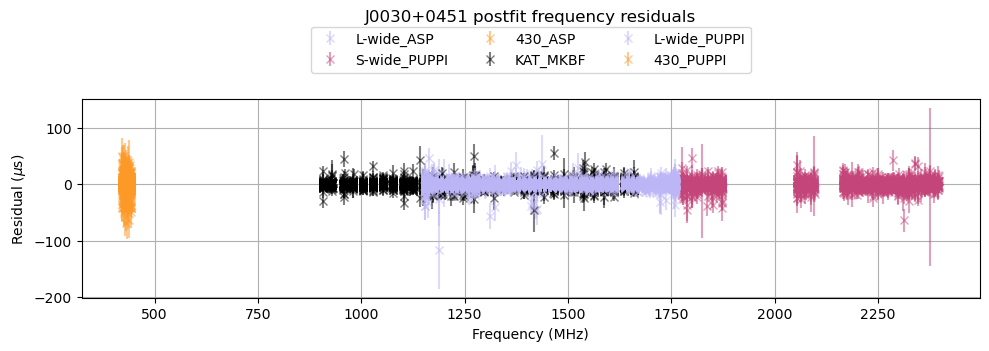

In [33]:
# Plot post-fit residuals, print summary of results, write prenoise solution
pu.plot_residuals_time(fo, restype='postfit')
report.add_plot("Postfit residuals")
if mo.is_binary:
    pu.plot_residuals_orb(fo, restype='postfit')
    report.add_plot("Postfit residuals")
pu.plot_residuals_freq(fo, restype='postfit')
report.add_plot("Postfit residuals")
    
summary = fo.get_summary()
report.add_markdown("Fit summary", f"```\n{summary}\n```")
lu.check_convergence(fo)

lu.write_par(fo,toatype=tc.get_toa_type(),addext='_prenoise')
lu.write_tim(fo, toatype=tc.get_toa_type(), addext='_prenoise')

# generate \[summary\] report

In [ ]:
# Generate the PDF report
report.generate_pdf(f"{tc.get_source()}-pint-summary.pdf")